# English speech emotion recognition (SER) :

In [4]:
from art import text2art,tprint,art
tprint('Welcome',font='block',chr_ignore=True)


 .----------------.  .----------------.  .----------------.  .----------------.  .----------------.  .----------------.  .----------------. 
| .--------------. || .--------------. || .--------------. || .--------------. || .--------------. || .--------------. || .--------------. |
| | _____  _____ | || |  _________   | || |   _____      | || |     ______   | || |     ____     | || | ____    ____ | || |  _________   | |
| ||_   _||_   _|| || | |_   ___  |  | || |  |_   _|     | || |   .' ___  |  | || |   .'    `.   | || ||_   \  /   _|| || | |_   ___  |  | |
| |  | | /\ | |  | || |   | |_  \_|  | || |    | |       | || |  / .'   \_|  | || |  /  .--.  \  | || |  |   \/   |  | || |   | |_  \_|  | |
| |  | |/  \| |  | || |   |  _|  _   | || |    | |   _   | || |  | |         | || |  | |    | |  | || |  | |\  /| |  | || |   |  _|  _   | |
| |  |   /\   |  | || |  _| |___/ |  | || |   _| |__/ |  | || |  \ `.___.'\  | || |  \  `--'  /  | || | _| |_\/_| |_ | || |  _| |___/ |  | |
| |  |__/  \

# **imports:**

In [1]:
from colorama import Fore
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from IPython.display import Audio
import librosa   # Audio preprocessing package
import librosa.display as disp
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from pydub import AudioSegment

In [3]:
from keras.layers import Dense,Dropout,LSTM,TimeDistributed,Flatten,BatchNormalization , Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Conv1D
from keras.optimizers import Adam  # optimization technique
from keras.callbacks import ReduceLROnPlateau , EarlyStopping , TensorBoard , ModelCheckpoint
from keras.models import load_model
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import pickle

2024-12-25 23:07:00.874491: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-25 23:07:00.890561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-25 23:07:00.909858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-25 23:07:00.915365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-25 23:07:00.928561: I tensorflow/core/platform/cpu_feature_guar

# **data collection:**

In [4]:
import zipfile
import os

def unzip_file(zip_filepath, extract_to='.'):
    """
    Unzips the specified zip file to the target directory.

    :param zip_filepath: Path to the .zip file
    :param extract_to: Directory where files will be extracted (default: current directory)
    """
    # Ensure the target directory exists
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Unzipped '{zip_filepath}' to '{extract_to}'.")

zip_file_path = 'speech-emotion-recognition-ravdess-data.zip'
unzip_file(zip_file_path)

Unzipped 'speech-emotion-recognition-ravdess-data.zip' to '.'.


In [5]:
path : str= 'speech-emotion-recognition-ravdess-data//'

def load_data(path):
    f_emotions:list[str] = []
    f_pathes:list[str] = []

    folders = os.listdir(path)
    for folder in tqdm(folders,desc='gathering folders:'):
        files = os.listdir(path+folder)
        for file in tqdm(files,desc='gathering files:'):
            step = file.split('.')[0]
            step = step.split('-')[2]
            f_emotions.append(int(step))
            f_pathes.append(path+folder+os.sep+file)
    return [f_emotions,f_pathes]

# **data pre-processing and visualization:**(and data augmentation)

In [6]:
def get_emotion(number):
    info:dict={1:'neutral',2:'calm',3:'happy',4:'sad',5:'angry',6:'fearful',7:'disgust',8:'surprised'}
    return info[number]

def read_audio(path):
    data,sample_rate = librosa.load(path,duration=2.4,offset=0.6)
    return data,sample_rate

def draw_wave(path,data,sr):
    # data , sr = librosa.load(path)
    plt.title('audio wave: '+path)
    disp.waveshow(data,sr=sr)
    plt.show()

def draw_spectogram(path,data,sr):
    # data,sr = librosa.load(path)
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(x)
    plt.title('spectogram for wave: '+path)
    disp.specshow(xdb,sr=sr)
    plt.show()
    
def add_noise(data,sr):
    noise = 0.035*np.random.uniform()*np.amax(data)
    data += noise*np.random.normal(size=data.shape[0])
    return data,sr
    
def shift(data,sr):
    shift_range = int(np.random.uniform(low=-5,high=5)*1000)
    shifted = np.roll(data,shift_range)
    return shifted,sr

def pitch(data,sr,factor=0.7):
    pitched = librosa.effects.pitch_shift(y=data,sr=sr,n_steps=factor)
    return pitched,sr

def strech(data,sr,rate=0.85):
    streched = librosa.effects.time_stretch(y=data,rate=0.85)
    
def feature_extraction(data,sr):
    mfcc = librosa.feature.mfcc(y=data,sr=sr)
    return mfcc

def processing_audio(data,sr,options):
    func = random.choice(options)
    if func =='Standard':
        processed = data
    else:
        processed,_ = func(data,sr)
    return processed
#______________________________________________________________________________
def get_features(path):
    data,sample_rate = read_audio(path)
    funcs = ['Standard',add_noise,pitch]
    
    features:list = []
    
    func1_data = processing_audio(data,sample_rate,funcs)
    func2_data = processing_audio(func1_data,sample_rate,funcs)
    
    feature =  feature_extraction(func2_data,sample_rate)
    
    if feature.shape == (20,104):
        features.append(feature)
    
    func1_data = processing_audio(data,sample_rate,funcs)
    func2_data = processing_audio(func1_data,sample_rate,funcs)
    
    feature =  feature_extraction(func2_data,sample_rate)
    
    if feature.shape == (20,104):
        features.append(feature)
        
    func1_data = processing_audio(data,sample_rate,funcs)
    func2_data = processing_audio(func1_data,sample_rate,funcs)
    
    feature =  feature_extraction(func2_data,sample_rate)
    
    if feature.shape == (20,104):
        features.append(feature)    
        
    get_features.num_of_features = len(features)
    
    return features
#____________________________________________________________________________________
def display(number):
    data,sample_rate = read_audio(pathes[number])
    mfcc_features = feature_extraction(data,sample_rate)
    print(len(mfcc_features))
    print('emotion ->',get_emotion(emotions[number]))
    # data,sample_rate = add_noise(data,sample_rate)
    data,sample_rate = pitch(data,sample_rate)
    draw_wave(pathes[number],data,sample_rate)
    draw_spectogram(pathes[number],data,sample_rate)
    return data , sample_rate

emotions , pathes = load_data(path)

gathering folders:: 100%|██████████| 24/24 [00:00<00:00, 292.64it/s]


**Simple EDA :**

In [9]:
from pydub import AudioSegment
import os
print(Fore.YELLOW)

file_path : str= "speech-emotion-recognition-ravdess-data/Actor_01//03-01-01-01-01-01-01.wav"  # Replace with the path to your MP3 audio file

try:
    if os.path.exists(file_path):
        audio = AudioSegment.from_mp3(file_path)

        num_channels = audio.channels
        sample_width = audio.sample_width
        frame_rate = audio.frame_rate
        num_frames = len(audio)
        
        print("Audio File Information:")
        print(f"Number of Channels: {num_channels}")
        print(f"Sample Width: {sample_width} bytes")
        print(f"Frame Rate: {frame_rate} Hz")
        print(f"Number of Frames: {num_frames}")

        print("Successfully read audio data.")

    else:
        print("File not found.")

except Exception as e:
    print("Error:", e)


Audio File Information:
Number of Channels: 1
Sample Width: 2 bytes
Frame Rate: 16000 Hz
Number of Frames: 3303
Successfully read audio data.


20
emotion -> fearful


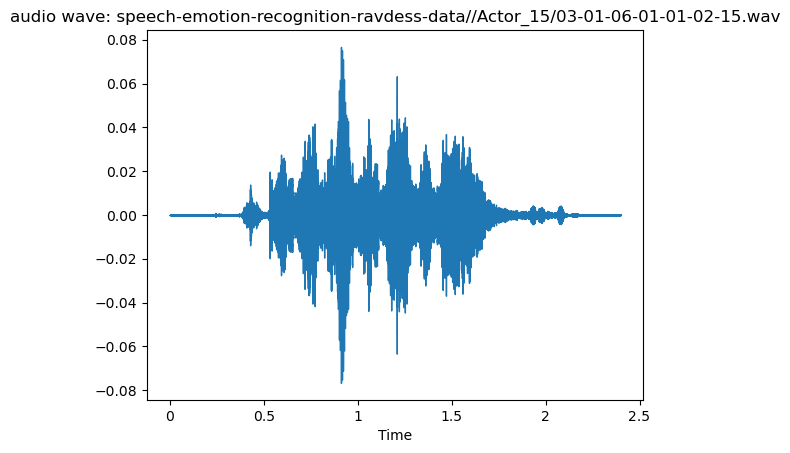

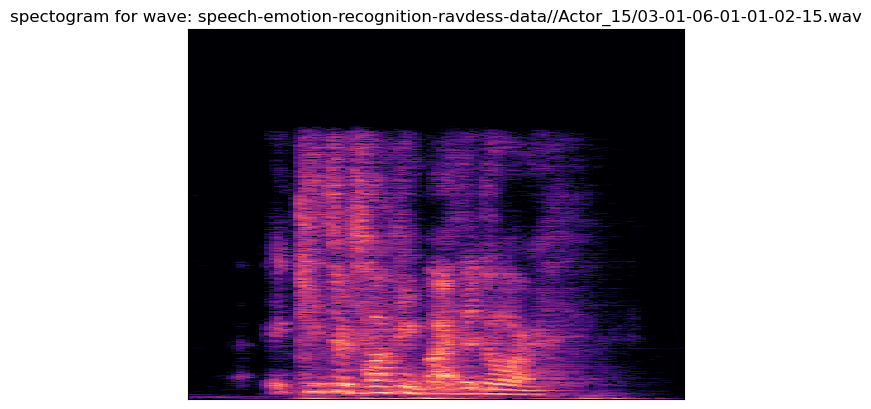

In [10]:
data ,sr = display(40)
Audio(data=data,rate=sr)

In [11]:
from tqdm import tqdm
# takes some time to process (5 mins max)
x = []
y = []
for indx in tqdm(range(len(pathes)),desc='extracting features'):
    value = get_features(pathes[indx])
    if value !=[]:
        for item in value:
            x.append(item)
            y.append(np.eye(8)[emotions[indx]-1])

extracting features: 100%|██████████| 1440/1440 [01:26<00:00, 16.74it/s]


# **splitting data phase:**

In [15]:
x_train , x_test , y_train , y_test = train_test_split(np.array(x),np.array(y),test_size=0.2,random_state=11,shuffle=True)

In [16]:
print('train x shape: ',x_train.shape)
print('test x shape: ',x_test.shape)
print('train y shape: ',y_train.shape)
print('test y shape: ',y_test.shape)

train x shape:  (3451, 20, 104)
test x shape:  (863, 20, 104)
train y shape:  (3451, 8)
test y shape:  (863, 8)


# Gender Recognition :

In [37]:
scaler = StandardScaler()

In [38]:
#  pretrained-gender model
with open('svm_model.pkl', 'rb') as file:
    Gmodel = pickle.load(file)

In [ ]:
# import joblib

# saved_model = joblib.load('svm_model.pkl')

In [39]:
# Function to extract features from audio file
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path)  # Load audio file
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        # Extract MFCC features MFCC stands for Mel Frequency Cepstral Coefficients,
        # and it is a feature extraction technique widely used in the field of speech and audio signal processing.
        # MFCCs are commonly employed for tasks like speech recognition, speaker identification, and audio classification
    features = np.mean(mfccs.T, axis=0)  # Take the mean of MFCCs along the time axis
    return features

In [40]:
features = extract_features('speech-emotion-recognition-ravdess-data\Actor_01\\03-01-01-01-01-01-01.wav')

In [41]:
features = scaler.fit_transform([features])

In [42]:
# Function to convert MP3 to WAV
def convert_mp3_to_wav(mp3_file_path, output_wav_file_path):
    audio = AudioSegment.from_mp3(mp3_file_path)
    audio.export(output_wav_file_path, format="wav")

In [43]:
def detect_gender(file_path):
    # Convert MP3 to WAV if necessary
    if file_path.lower().endswith('.mp3'):
        wav_file_path = os.path.splitext(file_path)[0] + ".wav"
        convert_mp3_to_wav(file_path, wav_file_path)
        file_path = wav_file_path

    features = extract_features(file_path)
    features = scaler.transform([features])  # Normalize the input features
    prediction = Gmodel.predict(features)[0]  # Make a prediction
    return prediction

In [44]:
detect_gender('speech-emotion-recognition-ravdess-data\Actor_01\\03-01-01-01-01-01-01.wav')

'male'

# post-processing phase:

In [17]:
# expanding and swapping dimensions
train_x = np.expand_dims(x_train,axis=-1)
train_x = np.swapaxes(train_x,1,2)
print('train_x: ',train_x.shape)

test_x = np.expand_dims(x_test,axis=-1)
test_x = np.swapaxes(test_x,1,2)
print('test_x: ',test_x.shape)

inputshape = train_x.shape[1:]

train_x:  (3451, 104, 20, 1)
test_x:  (863, 104, 20, 1)


# **model creation:**

In [18]:
def createmodel(inputshape):
    model = Sequential(name='LSTM')
    model.add(TimeDistributed(Conv1D(32,3,padding='same',activation='relu'),input_shape=inputshape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(units=64,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=64,activation='relu'))
    model.add(Dense(units=8,activation='softmax'))
    return model
    

In [19]:
# After fixing the shape to (3451, 104, 20, 1):
input_shape = train_x.shape[1:]  # (104, 20, 1)

model = createmodel(input_shape)
model.summary()


2024-12-25 23:14:18.653949: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-25 23:14:18.654097: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: prowler
2024-12-25 23:14:18.654339: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: prowler
2024-12-25 23:14:18.657047: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 550.120.0
2024-12-25 23:14:18.657368: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 550.120.0
2024-12-25 23:14:18.657393: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 550.120.0


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 104, 20, 32)    │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 104, 20, 32)    │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 104, 640)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       180,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,576 (740.53 KB)

 Trainable params: 189,512 (740.28 KB)

 Non-trainable params: 64 (256.00 B)

# **training phase:**

In [22]:
print(Fore.CYAN)
# also takes some time
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
reduce = ReduceLROnPlateau(monitor='val_loss',factor=0.6,verbose=1,patience=5,min_lr=1e-8)  # 1e-8 -> 0.000000001
stop = EarlyStopping(monitor='val_loss',patience=7)
saving = ModelCheckpoint(filepath="best.keras")

history = model.fit(train_x,y_train,batch_size=140,epochs=60,validation_data=(test_x,y_test),callbacks=[reduce,stop,saving])


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 850ms/step - accuracy: 0.1723 - loss: 2.0485 - val_accuracy: 0.2654 - val_loss: 1.8876 - learning_rate: 0.0100
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 705ms/step - accuracy: 0.2568 - loss: 1.8920 - val_accuracy: 0.2457 - val_loss: 1.8661 - learning_rate: 0.0100
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 709ms/step - accuracy: 0.2592 - loss: 1.8345 - val_accuracy: 0.3036 - val_loss: 1.7068 - learning_rate: 0.0100
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 710ms/step - accuracy: 0.3341 - loss: 1.6875 - val_accuracy: 0.3024 - val_loss: 1.7501 - learning_rate: 0.0100
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 710ms/step - accuracy: 0.3465 - loss: 1.6494 - val_accuracy: 0.3210 - val_loss: 1.6709 - learning_rate: 0.0100
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 709ms/step - accuracy: 0.3789 - loss: 1.5909 - val_accuracy: 0.3882 - val_loss: 1.5911 - learning_rate: 0.0100
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 709ms/step - accuracy: 0.3892 - loss: 1

In [23]:
print(Fore.CYAN)
print('accuracy: ',model.evaluate(test_x,y_test)[1]*100,'%')


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5938 - loss: 1.1991
accuracy:  60.71842312812805 %


In [24]:
# saving model
model.save('model.keras')

# **testing phase (evaluation) :** 

### LSTM :

In [25]:
emotion_model = load_model('model.keras')  # accuracy:  63.6152982711792 %
y_pred = emotion_model.predict(test_x)

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step


In [26]:
print(Fore.CYAN)
weights , biases = model.layers[0].get_weights()
print("first hidden layer weights:",weights)
print("\n first hidden layer dimensions:",weights.shape)
print(" \n first hidden layer bias:",biases)
print("\n first hidden layer bias dimensions:",biases.shape)


first hidden layer weights: [[[-0.26496774  0.43739805  0.07453698  0.19405656  0.19474319
    0.88443124 -0.14252277 -0.8239229  -0.44788864 -0.38158098
    0.159838    0.30794898 -0.21289918  0.21158108 -0.8086512
    0.06110725  0.40252122  0.15929426 -0.04190496 -0.79559225
    0.2434033   0.36883432 -0.21238689 -0.12302073 -0.19422081
   -0.08363377 -0.55518097 -0.26660147  0.01483747 -0.6032666
    0.24008507  0.15224877]]

 [[ 0.17827377 -0.10991976  0.0108499   0.55159765  0.42256016
    0.20143308 -0.4425096   0.13008896  0.16526401  0.07116076
    0.54110223  0.64363474 -0.02270495  0.541128    0.03586071
   -0.24975157  0.11792196  0.5874122  -0.19382921 -0.02667828
    0.12887745  0.28041503  0.25086066 -0.55955505 -0.330472
   -0.5047094  -0.09402876  0.07731162 -0.38898954  0.10615487
   -0.12335582  0.64906025]]

 [[-0.40986487 -0.5357729  -1.5113834  -0.46312264 -0.37565845
   -0.04299018 -0.5368983   0.21039331  0.69815487 -0.49879548
    0.26968625  0.17540213 -0.692

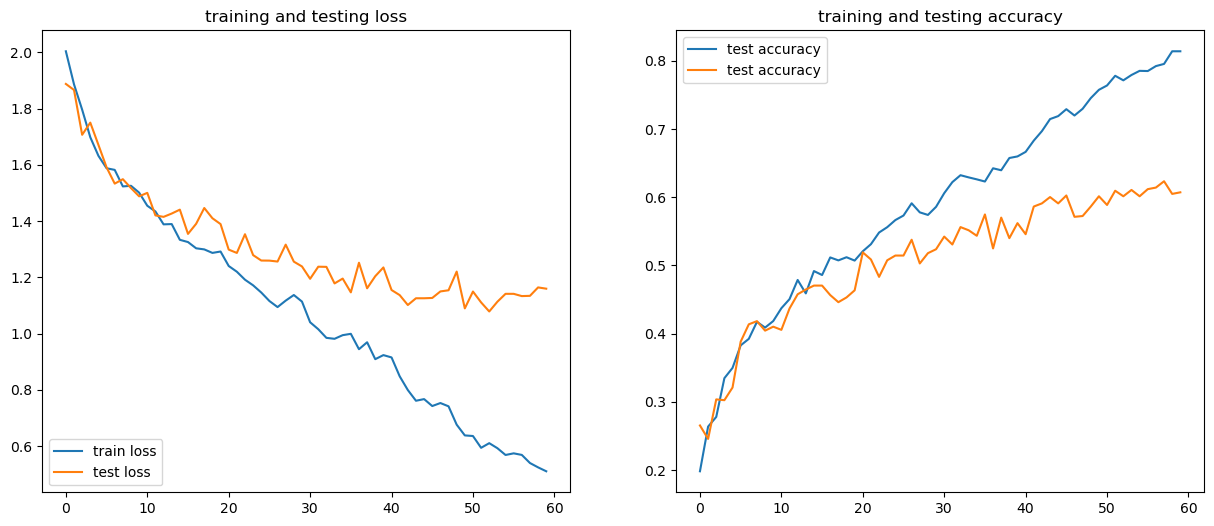

In [27]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
fig,ax = plt.subplots(1,2)
fig.set_size_inches(15,6)
#______________________________________________________________
ax[0].plot(train_loss)
ax[0].plot(test_loss)
ax[0].set_title('training and testing loss')
ax[0].legend(['train loss','test loss'],loc='lower left')
#______________________________________________________________
ax[1].plot(train_accuracy)
ax[1].plot(test_accuracy)
ax[1].set_title('training and testing accuracy')
ax[1].legend(['test accuracy','test accuracy'],loc='upper left')
#______________________________________________________________
plt.show()

In [28]:
encoder = OneHotEncoder()
encoder.fit_transform(np.array([1,2,3,4,5,6,7,8]).reshape(-1,1)).toarray() # 8 classes

pred_y = encoder.inverse_transform(y_pred)
test_y = encoder.inverse_transform(y_test)

emotion_predictions = [get_emotion(value) for value in pred_y.flatten()]
emotion_actual = [get_emotion(value) for value in test_y.flatten()]

df = pd.DataFrame(columns=['actual emotions','predicted emotions'])
df['actual emotions'] = emotion_actual
df['predicted emotions'] = emotion_predictions

df.head(10)

,actual emotions,predicted emotions
0,happy,fearful
1,happy,happy
2,happy,happy
3,neutral,disgust
4,happy,happy
5,happy,sad
6,fearful,surprised
7,neutral,happy
8,disgust,surprised
9,angry,angry


In [29]:
from collections import Counter  # built-in function
classes = Counter(list(df['predicted emotions']))
print(classes)

Counter({'fearful': 136, 'happy': 126, 'angry': 122, 'calm': 118, 'surprised': 115, 'neutral': 96, 'sad': 86, 'disgust': 64})


Text(0.5, 0, '# of Occurances')

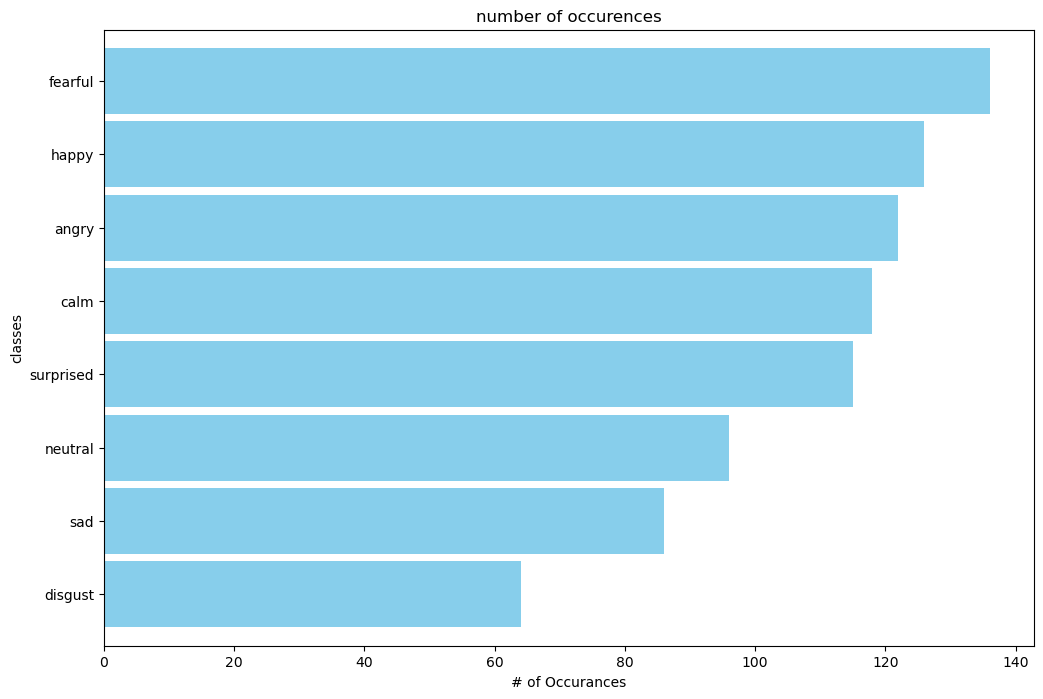

In [30]:
unigrams = (pd.Series(list(df['predicted emotions'])).value_counts()) 
unigrams.sort_values().plot.barh(color='skyblue', width=.9, figsize=(12, 8))
plt.title('number of occurences')
plt.ylabel('classes')
plt.xlabel('# of Occurances')

In [31]:
# saving dataframe
df.to_csv('results.csv')

In [32]:
# get no. of features
get_features(pathes[5])
get_features.num_of_features

3

# Confusion Matrix :

Text(120.72222222222221, 0.5, 'Actual Emotions')

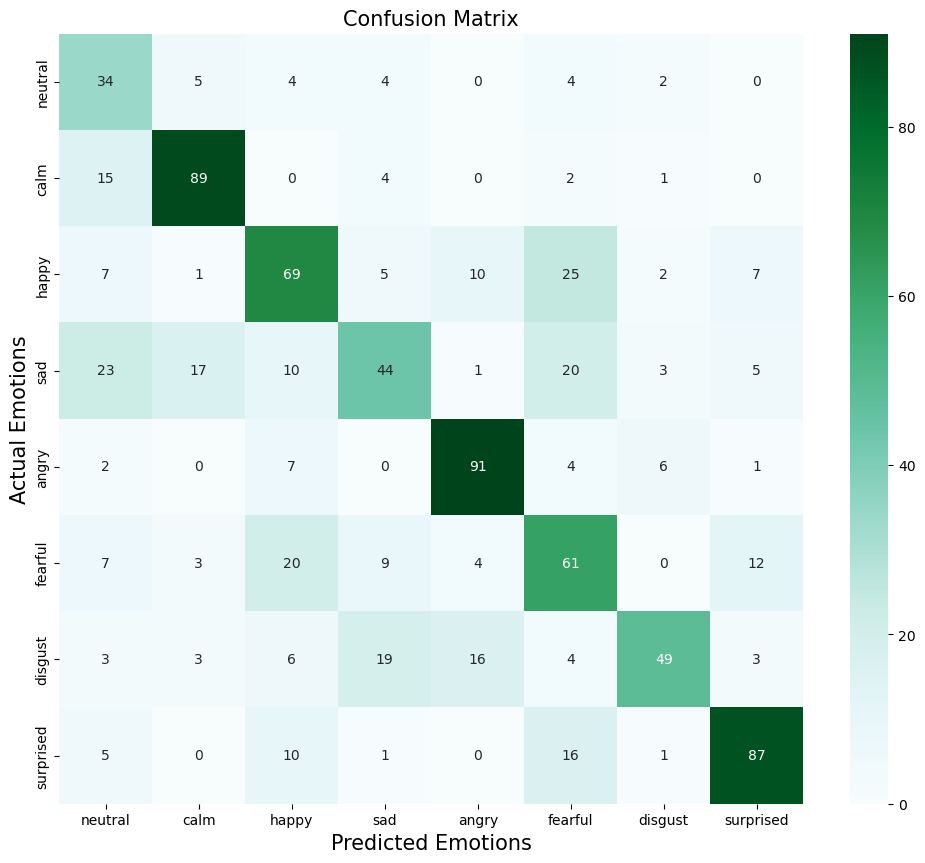

In [33]:
cm =confusion_matrix(test_y,pred_y)

emts = [get_emotion(em) for em in encoder.categories_[0]]

cmt = pd . DataFrame(cm ,index=emts, columns=emts)
plt.figure(figsize=(12,10))
sns.heatmap(cmt,annot=True, fmt='',cmap='BuGn')
plt.title('Confusion Matrix', size = 15)
plt.xlabel('Predicted Emotions', size = 15)
plt.ylabel('Actual Emotions',size=15)

# tensorboard :

In [ ]:
# Loading the Tensorboard extension
%load_ext tensorboard
%tensorboard --logdir "logs/fit"

# voice recorder and real-time input:

In [65]:
import sounddevice
from scipy.io.wavfile import write

def voice_recorder(seconds, file):
    print("Recording Started…")
    recording = sounddevice.rec((seconds * 44100), samplerate= 44100, channels=2)
    sounddevice.wait()
    write(file, 44100, recording)
    print("Recording Finished")

voice_recorder(10, "record.wav")

Recording Started…
Recording Finished


In [45]:
print(f"gender => {detect_gender('record.wav')}")

gender => male


In [46]:
emotion_model = load_model('emotion_model.h5') 

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder()
# encoder.fit_transform(np.array([1,2,3,4,5,6,7,8]).reshape(-1,1)).toarray()

In [36]:
with open('encoder.pkl','wb') as file:
    pickle.dump(encoder,file)

In [53]:
def emotion_detector(path:str):
    features = get_features(path)
    feat = np.array(features)
    input = np.expand_dims(feat,axis=3)
    input = np.expand_dims(input,axis=3)
    input = np.swapaxes(input,1,2)
    emotion=emotion_model.predict(input)
    pred = encoder.inverse_transform(emotion)
    pred = pred.flatten()
    prediction = [get_emotion(value) for value in pred]
    return prediction[1]

In [55]:
emotion = emotion_detector('record.wav')
print(emotion)

1/1 [==============================] - 0s 27ms/step
angry


In [27]:
def monitor(path:str) -> str:
    print(f"current emotion is {emotion_detector(path)}")
    print(f"gender is {detect_gender(path)}")

In [37]:
%pip install playsound==1.2.2   

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from playsound import playsound 
playsound('speech-emotion-recognition-ravdess-data/Actor_03/03-01-01-01-01-01-03.wav')
print('played sound using playsound')